## Validation on The Test Set
In this notebook, we will evaluate our trained models on the test set.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, roc_curve
import shap
shap.initjs()
import warnings
warnings.filterwarnings('ignore')
import helper_functions as hf

## Part I. Read In The Test Data and Prepare the Features

In [2]:
# read in the test data
test_data = pd.read_csv('data/test_set.csv')

In [3]:
# define the target variable and features
y_test = test_data['churn']
X_test = test_data.drop(columns=['churn'])

In [4]:
# verify that the target variable is not among features
'churn' in X_test.columns

False

In [5]:
# remove customer_id from features as it is not really a feature
X_test = X_test.drop(columns=['customer_id'])

In [6]:
# define the columns which we should normalize by the number of users in the future
columns_to_normalize = [
                        'revenue',
                        'mou',
                        'recurring_charge',
                        'director_assist', 
                        'overage',
                        'roaming',
                        'minutes_delta', 
                        'revenue_delta', 
                        'dropped_calls',
                        'blocked_calls',
                        'unanswered', 
                        'customer_care',
                        'mou_received',
                        'outcalls',
                        'incalls',
                        'peaks',
                        'off_peaks',
                        'call_forwarding',
                        'call_waiting',
                        'phones',
                        'models',
                        'accept_offer',
                        'referrals'
                        ]

In [7]:
# features we filtered out from the training set
features_to_remove = ['revenue_delta', 
                      'income', 
                      'call_forwarding', 
                      'conference', 
                      'referrals', 
                      'children', 
                      'suburban', 
                      'town', 
                      'truck', 
                      'rv', 
                      'job_prof', 
                      'job_clerical', 
                      'job_crafts', 
                      'job_student', 
                      'job_homemaker', 
                      'job_self', 
                      'travel', 
                      'pcown', 
                      'credit_card', 
                      'existing_user', 
                      'motorcycle']

In [8]:
# save the columns that have missing values
cols_with_missing = X_test.isnull().sum()[X_test.isnull().sum() > 0].index

In [9]:
# identify numerical and categorical features in a dataframe
numerical_features, categorical_features =  hf.numeric_and_categorical_features(X_test)

In [10]:
# define the features that should not have any negative values
non_negative_numerical = [col for col in numerical_features if col not in ['minutes_delta', 'revenue_delta']]

In [11]:
# load a pre-trained scaler for feature standardization
scaler = joblib.load('models/scaler.sav')

In [12]:
def prepare_features(df):
    """
    The function transforms the features following the steps we took with the training data.
    """
    df_copy = df.copy()
    # fill in null values and replace the noisy negative values in numerical cols with the mean
    df_copy = (df_copy.pipe(hf.fill_null_values, 
                           cols_with_missing=cols_with_missing)
                         ).pipe(hf.fill_negative_vals, 
                               numerical_features=numerical_features)
    # replace 0 with mean income
    df_copy['income'] = np.where(df_copy['income'] == 0, 
                                 df_copy['income'].mean(), 
                                 df_copy['income'])
    # find the ratio of revenue to income
    df_copy['revenue'] = df_copy['revenue'] / df_copy['income']
    # normalize the selected columns by the number of active users
    df_copy = (df_copy.pipe(hf.normalize_by_users, 
                            columns=columns_to_normalize
                     ).pipe(hf.log_transform, 
                            cols=non_negative_numerical))
    # standardize the numerical features with the pre-trained Standard Scaler
    df_copy_num_scaled = pd.DataFrame(scaler.transform(df_copy[numerical_features]),
                                                      columns = numerical_features)
    # combine the numerical features with the categorical
    combined_df = pd.concat([df_copy_num_scaled, 
                                  df_copy[categorical_features]], 
                                  axis=1)
    # remove filtered out features
    combined_df = combined_df.drop(features_to_remove, 
                                   axis=1)
    
    return combined_df

In [13]:
# for the features in the test, perform the same operations we did on the training set
X_test_preped = prepare_features(X_test)

In [14]:
X_test_preped.shape

(17052, 35)

In [15]:
X_test_preped.head()

,revenue,mou,recurring_charge,director_assist,overage,roaming,minutes_delta,dropped_calls,blocked_calls,unanswered,...,accept_offer,handset_price,credit_a,credit_aa,rural,refurbished,web_capable,job_retired,new_user,retcall
0,0.746089,0.083128,0.473803,0.246701,-0.828145,-1.286784,0.024089,-0.691949,2.204851,0.662229,...,0.069692,0.800862,1,0,0,0,1,0,0,1
1,-0.047756,0.300556,-0.334803,0.246701,0.822988,0.084762,-0.209963,0.198631,-0.867409,0.551873,...,0.069692,-0.823747,0,0,0,0,1,0,0,0
2,1.045247,1.112020,1.112513,1.778502,1.751923,-0.002221,0.671273,0.556799,1.826994,1.808187,...,0.069692,-0.823747,0,1,0,0,1,0,0,0
3,1.783338,0.620321,1.360113,-1.383941,-0.828145,0.084762,0.892291,0.923197,0.427440,1.703747,...,0.069692,1.569826,0,1,0,0,1,0,0,0
4,0.176632,-0.844618,-0.200684,0.246701,-0.828145,0.084762,-0.018981,-0.691949,-0.284772,-0.118164,...,0.069692,-0.823747,0,0,0,0,0,0,1,0


## Part II. Load Pre-Trained Models and Test Them

### 1. Logistic Regression (with l2 reguralization, C=1000)

In [16]:
# load the pre-trained logistic regression
lr = joblib.load('models/logistic_regression.sav')

In [17]:
# use it to make predictions for the test set
y_pred_lr = lr.predict_proba(X_test_preped)

### Roc-Auc Curve For Logistic Regression

In [18]:
# false positives, true positives, and thresholds for the logistic regression
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_pred_lr[:,1], pos_label=1)
# random probabilities
random_probs = [0 for i in range(len(y_test))]
r_fpr,r_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

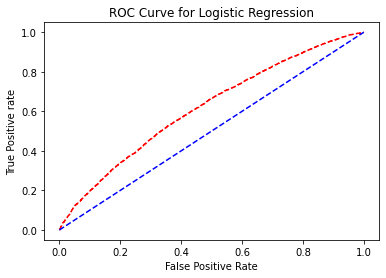

In [19]:
plt.title('ROC Curve for Logistic Regression')
plt.plot(fpr_lr, tpr_lr, linestyle='--',color='red', label='Logistic Regression')
plt.plot(r_fpr, r_tpr, linestyle='--', color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.show()

### Calculate Roc-Auc Score on The Test Set

In [20]:
print('roc-auc score:', format(roc_auc_score(y_test, 
                                             y_pred_lr[:, 1]), 
                                             '0.3f'))

roc-auc score: 0.618


### 2. Random Forest Classifier (max_depth = 12, number of estimators=700)

In [21]:
# load the pre-trained random forest
rfc = joblib.load('models/random_forest.sav')

In [22]:
# make predictions on the test set
y_pred_rfc = rfc.predict_proba(X_test_preped)

### Roc-Auc Curve For Random Forest

In [23]:
# false positives, true positives, and thresholds for the random forest
fpr_rfc, tpr_rfc, thresholds_rfc = roc_curve(y_test, y_pred_lr[:,1], pos_label=1)
# random probabilities
random_probs = [0 for i in range(len(y_test))]
r_fpr,r_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

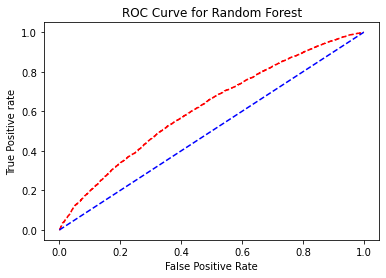

In [24]:
plt.title('ROC Curve for Random Forest')
plt.plot(fpr_rfc, tpr_rfc, linestyle='--',color='red', label='Random Forest')
plt.plot(r_fpr, r_tpr, linestyle='--', color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.show()

### Roc-Auc Score on The Test Set

In [25]:
print('roc-auc score:', format(roc_auc_score(y_test, 
                                             y_pred_rfc[:, 1]), 
                                             '0.3f'))

roc-auc score: 0.666


### 3. CatBoost (depth=4, iterations=300, learning_rate=0.1)

In [26]:
# load the pre-trained CatBoost
cat = joblib.load('models/catboost.sav')

In [27]:
# predict on the test set
y_pred_cat = cat.predict_proba(X_test_preped)

### Roc-Auc Curve for CatBoost

In [28]:
# false positives, true positives, and thresholds for the logistic regression
fpr_cat, tpr_cat, thresholds_cat = roc_curve(y_test, y_pred_cat[:,1], pos_label=1)
# random probabilities
random_probs = [0 for i in range(len(y_test))]
r_fpr,r_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

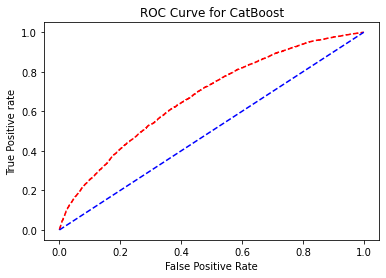

In [29]:
plt.title('ROC Curve for CatBoost')
plt.plot(fpr_cat, tpr_cat, linestyle='--',color='red', label='CatBoost')
plt.plot(r_fpr, r_tpr, linestyle='--', color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.show()

### Roc-Auc Score for CatBoost

In [30]:
print('roc-auc score:', format(roc_auc_score(y_test, 
                                             y_pred_cat[:, 1]), 
                                             '0.3f'))

roc-auc score: 0.673


## Part III. Feature Importances

Here, we will use shap values for evaluating feature importances for each model. 
For more information, see https://github.com/slundberg/shap. Features are ranked according to their shap values, with the most impactful features at the top. Red color of the feature means the high value of that feature, whereas the blue color means the low value of that feature.

### 1. Shap Values for Churn (Logistic Regression)

In [31]:
explainer_linear = shap.LinearExplainer(lr, X_test_preped, feature_dependence="independent")
shap_values_linear = explainer_linear.shap_values(X_test_preped)

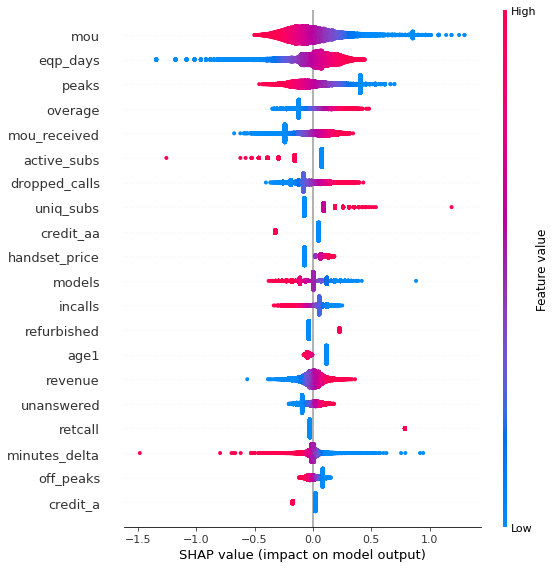

In [32]:
shap.summary_plot(shap_values_linear, 
                  X_test_preped.values, 
                  feature_names=X_test_preped.columns)

### The Most Important Features (Based on Logistic Regression Shap Values) Associated With Churn:
- Low (blue in color) average monthly minutes;
- High number of days (red in color) on current phone;
- Low number (blue) of calls during peak hours;
- High (red) overage minutes used;
- High number (red) of minutes received;
- Low number of active subscribers;
- High average number of dropped voice calls;
- High number of unique users;
- Fewer instances of having the highest credit score of AA;
- Higher handset price;
- Lower number of of unique phone models;
- Lower average number of inbound calls;
- Higher number of refurbished phones;
- Lower age of the first household member.
- Higher average monthly revenue;
- Higher average number of unanswered calls;
- Higher number of retention calls;
- Negative % of change in minutes of use;
- Mostly lower average number of calls during off-peak hours.
- Fewer instances of having the highest credit score of A.

### 2. Shap Values for Churn (CatBoost)

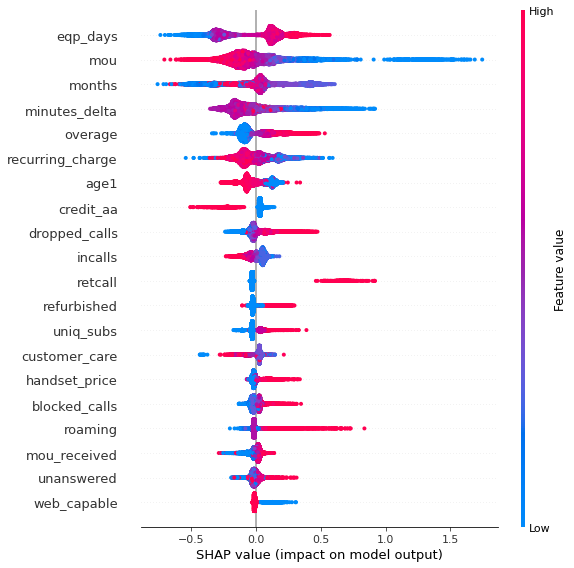

In [33]:
# initialize the tree explainer
cat_explainer = shap.TreeExplainer(cat)
# get the shap values
shap_values_cat = cat_explainer.shap_values(X_test_preped)
# plot them
shap.summary_plot(shap_values_cat, X_test_preped)

### The Most Important Features (Based on Cat Boost Shap Values) Associated With Churn:
- High number of days (red in color) on current phone;
- Low (mostly blue, mixed color means interaction with another feature) average monthly minutes used;
- Fewer (mostly blue) months in service;
- Negative (blue) % of change in the minutes used;
- High (red) overage minutes used;
- Predominantly lower recurring charge;
- Mostly lower age of the first household member;
- Fewer instances of having the highest credit score of AA;
- Higher number of dropped calls;
- Lower average number of inbound calls;
- More calls to retention;
- Higher number of refurbished phones;
- Higher number of unique subscribers;
- Lower (mostly) average number of calls to customer care;
- Higher handset price;
- Higher average number of blocked voice calls;
- Higher number of roaming calls;
- Higher number of minutes received;
- Higher number of unanswered phone calls;
- Not having web capabilities.

### 3. Feature Importances for Random Forest

Unforuntately, we ran out of time to run Shap values for the Random Forest model as it takes a long time. Instead, we extracted feature importances from the model itself. Unfortunately, these importances do not tell us whether a low or high feature value is associated with churn. More investigation with Shap values should be performed in the future.

In [34]:
# get feature importances from the model
importances_rfc = pd.DataFrame()
importances_rfc['importances'] = rfc.feature_importances_
importances_rfc['features'] = X_test_preped.columns.tolist()
importances_rfc = importances_rfc.sort_values(by='importances', ascending=False)

### Top Ten Features

In [35]:
importances_rfc.iloc[:10, :]

,importances,features
22,0.101027,eqp_days
17,0.082585,months
6,0.069361,minutes_delta
1,0.058707,mou
2,0.050794,recurring_charge
0,0.046866,revenue
4,0.040564,overage
14,0.039470,peaks
15,0.038538,off_peaks
11,0.037506,mou_received


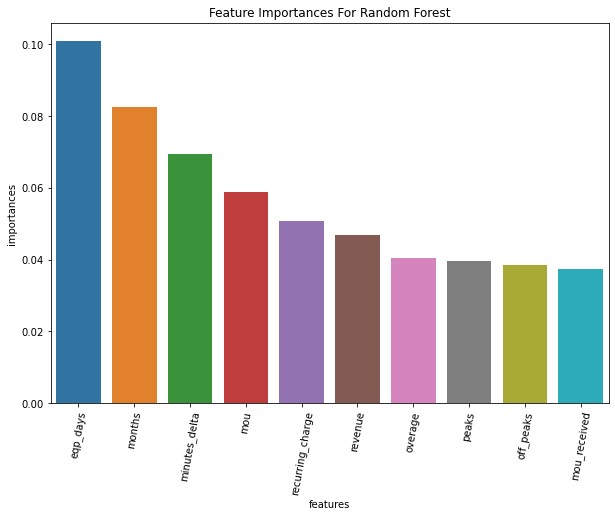

In [36]:
plt.figure(figsize=(10, 7))
plt.title('Feature Importances For Random Forest')
sns.barplot(x=importances_rfc.iloc[:10, :]['features'],
            y=importances_rfc.iloc[:10, :]['importances'])
plt.xticks(rotation=80)
plt.show()

#### Top Ten Features Impacting Churn
1. Number of days of current phone;
2. Months in service;
3. % change in minutes of use;
4. Average monthly minutes of use;
5. Total recurring charge;
6. Average monthly revenue;
7. Overage minutes used;
8. Average number of calls during peak hours;
9. Average number of calls during off-peak hours;
10. Minutes of voice calls received.

## Part IV. Conclusion 

Our models performed better than random, yet, there is much room for improvement. It would be useful to get the models to get roc-auc of at least 0.7. It is also useful to define our business goals (whether we care more about true positives (identifying as many churning customers as possible) or false positives (worry to give incentives to the customers who we think are churning but actually are not). This decision will impact the threshold we use to make predictions and will determine the confusion matrix we get as a result. We have obtained shap values and feature importances, which gave us some indication of the features impacting churn. However, since our models did not perform extremely well, these importances should be taken with the grain of salt. The analysis should be repeated once we get a better roc-auc score.